# Optimizing LLM Inference with BentoML's llm-optimizer

This notebook demonstrates how to find optimal serving configurations for deploying the Qwen/Qwen3-4B model on Amazon SageMaker AI using BentoML's llm-optimizer tool.

## Why Optimize?

Without systematic optimization, teams face an expensive guessing game between over-provisioning GPU resources and risking degraded user experience. Misconfigured setups can unnecessarily allocate more GPUs while delivering 2-3x higher latency. What would traditionally take days or weeks of manual trial-and-error becomes a few hours of automated benchmarking.

## Key Performance Concepts

Before diving into optimization, let's understand the key metrics:

### Performance Metrics
- **Throughput (requests/second)**: How many requests your system completes per second
- **Latency (seconds)**: Total time from request arrival until complete response
- **TTFT (Time to First Token)**: How quickly the first token is generated
- **ITL (Inter-Token Latency)**: Time between subsequent tokens

### The Throughput-Latency Trade-off
As you increase throughput, latency typically rises:
- Larger batch sizes → More requests processed together → Higher throughput
- More concurrent requests → Longer queue wait times → Higher latency
- Tensor parallelism → Distributes model across GPUs → Affects both metrics differently

### Roofline Analysis
The roofline model helps identify whether your workload is:
- **Memory-bound**: Limited by data transfer speed (typical for small batch sizes)
- **Compute-bound**: Limited by raw GPU processing power (typical for large batch sizes)

## Setup and install

In [ ]:
!pip install vllm

In [ ]:
!pip install git+https://github.com/bentoml/llm-optimizer.git

## Run an estimate

In [2]:
!llm-optimizer estimate --model Qwen/Qwen3-4B --gpu L40 --input-len 1024 --output-len 512

Auto-detected 4 GPU(s)
config.json: 100%|█████████████████████████████| 726/726 [00:00<00:00, 12.2MB/s]
💡 Inferred precision from model config: bf16

=== Configuration ===
Model: Qwen/Qwen3-4B
GPU: 4x L40
Precision: bf16
Input/Output: 1024/512 tokens
Target: throughput

Fetching model configuration...
Model: 3668377600.0B parameters, 36 layers

=== Performance Analysis ===
Best Latency (concurrency=1):
  TTFT: 16.8 ms
  ITL: 1.4 ms
  E2E: 0.72 s

Best Throughput (concurrency=1024):
  Output: 21601.0 tokens/s
  Input: 61062.1 tokens/s
  Requests: 24.71 req/s
  Bottleneck: Memory

=== Roofline Analysis ===
Hardware Ops/Byte Ratio: 195.1 ops/byte
Prefill Arithmetic Intensity: 31846.2 ops/byte
Decode Arithmetic Intensity: 31.1 ops/byte
Prefill Phase: Compute Bound
Decode Phase: Memory Bound

=== Concurrency Analysis ===
KV Cache Memory Limit: 1258 concurrent requests
Prefill Compute Limit: 21 concurrent requests
Decode Capacity Limit: 25 concurrent requests
Theoretical Overall Limit: 21 co

### Understanding the Estimate Output

The estimate command performs **roofline analysis** to predict LLM serving performance:

1. **Fetches model architecture** from HuggingFace (parameters, layers, attention heads)
2. **Calculates theoretical FLOPs** for prefill and decode phases
3. **Compares arithmetic intensity** against GPU hardware characteristics
4. **Determines bottlenecks**: Whether prefill/decode are memory-bound or compute-bound
5. **Estimates latency metrics**: TTFT, ITL, and end-to-end latency
6. **Calculates concurrency limits**: KV cache capacity, prefill compute, decode throughput

The output provides tuning commands for empirical benchmarking to validate theoretical predictions.

## Run a benchmark

Expect the runtime for the following step to increase exponentially as you add additional inference arg permutations 

### Understanding the Benchmark Process

The benchmark transitions from theoretical estimation to empirical validation:

- **Launches distributed benchmarking**: Tests each permutation of server/client arguments
- **Spins up vLLM instances**: With specified tensor parallelism, batch size, token limits
- **Drives load**: Using synthetic or dataset-based request generator (ShareGPT)
- **Captures metrics**: TTFT, ITL, end-to-end latency, tokens/sec, GPU memory utilization
- **Identifies Pareto frontier**: Configurations that best balance latency and throughput

**Note**: This step can take significant time depending on the number of permutations:
- 3 tensor_parallel_size × 3 max_num_batched_tokens = 9 server configs
- 3 max_concurrency settings = 3 client configs
- Total: 9 × 3 = **27 different test runs**

In [ ]:
!llm-optimizer \
  --framework vllm \
  --model Qwen/Qwen3-4B \
  --server-args "tensor_parallel_size=[1,2,4];max_num_batched_tokens=[4096,8192,16384]" \
  --client-args "max_concurrency=[32,64,128];num_prompts=1000;dataset_name=sharegpt" \
  --output-json vllm_results.json

## View Results

### Interpreting the Results

The benchmark generates three artifacts:

1. **HTML Pareto dashboard**: Interactive visualization of latency vs throughput trade-offs
2. **JSON summary**: Aggregated performance metrics for programmatic analysis
3. **JSONL detailed records**: Full record of individual benchmark runs for fine-grained inspection

**Key findings from typical benchmarks**:
- Tensor parallelism of 4 (across all GPUs) consistently outperforms lower settings
- Optimal config: `tensor_parallel_size=4`, `max_num_batched_tokens=8192`, `max_concurrency=128`
- This can achieve ~7.5 req/s and 2,270 input tokens/s (2.7x improvement over naive baseline)
- For latency-sensitive workloads: Use moderate concurrency (32) to maintain sub-24s p99 latency while still doubling throughput

In [ ]:
!llm-optimizer visualize --data-file vllm_results.json --port 8080 --serve

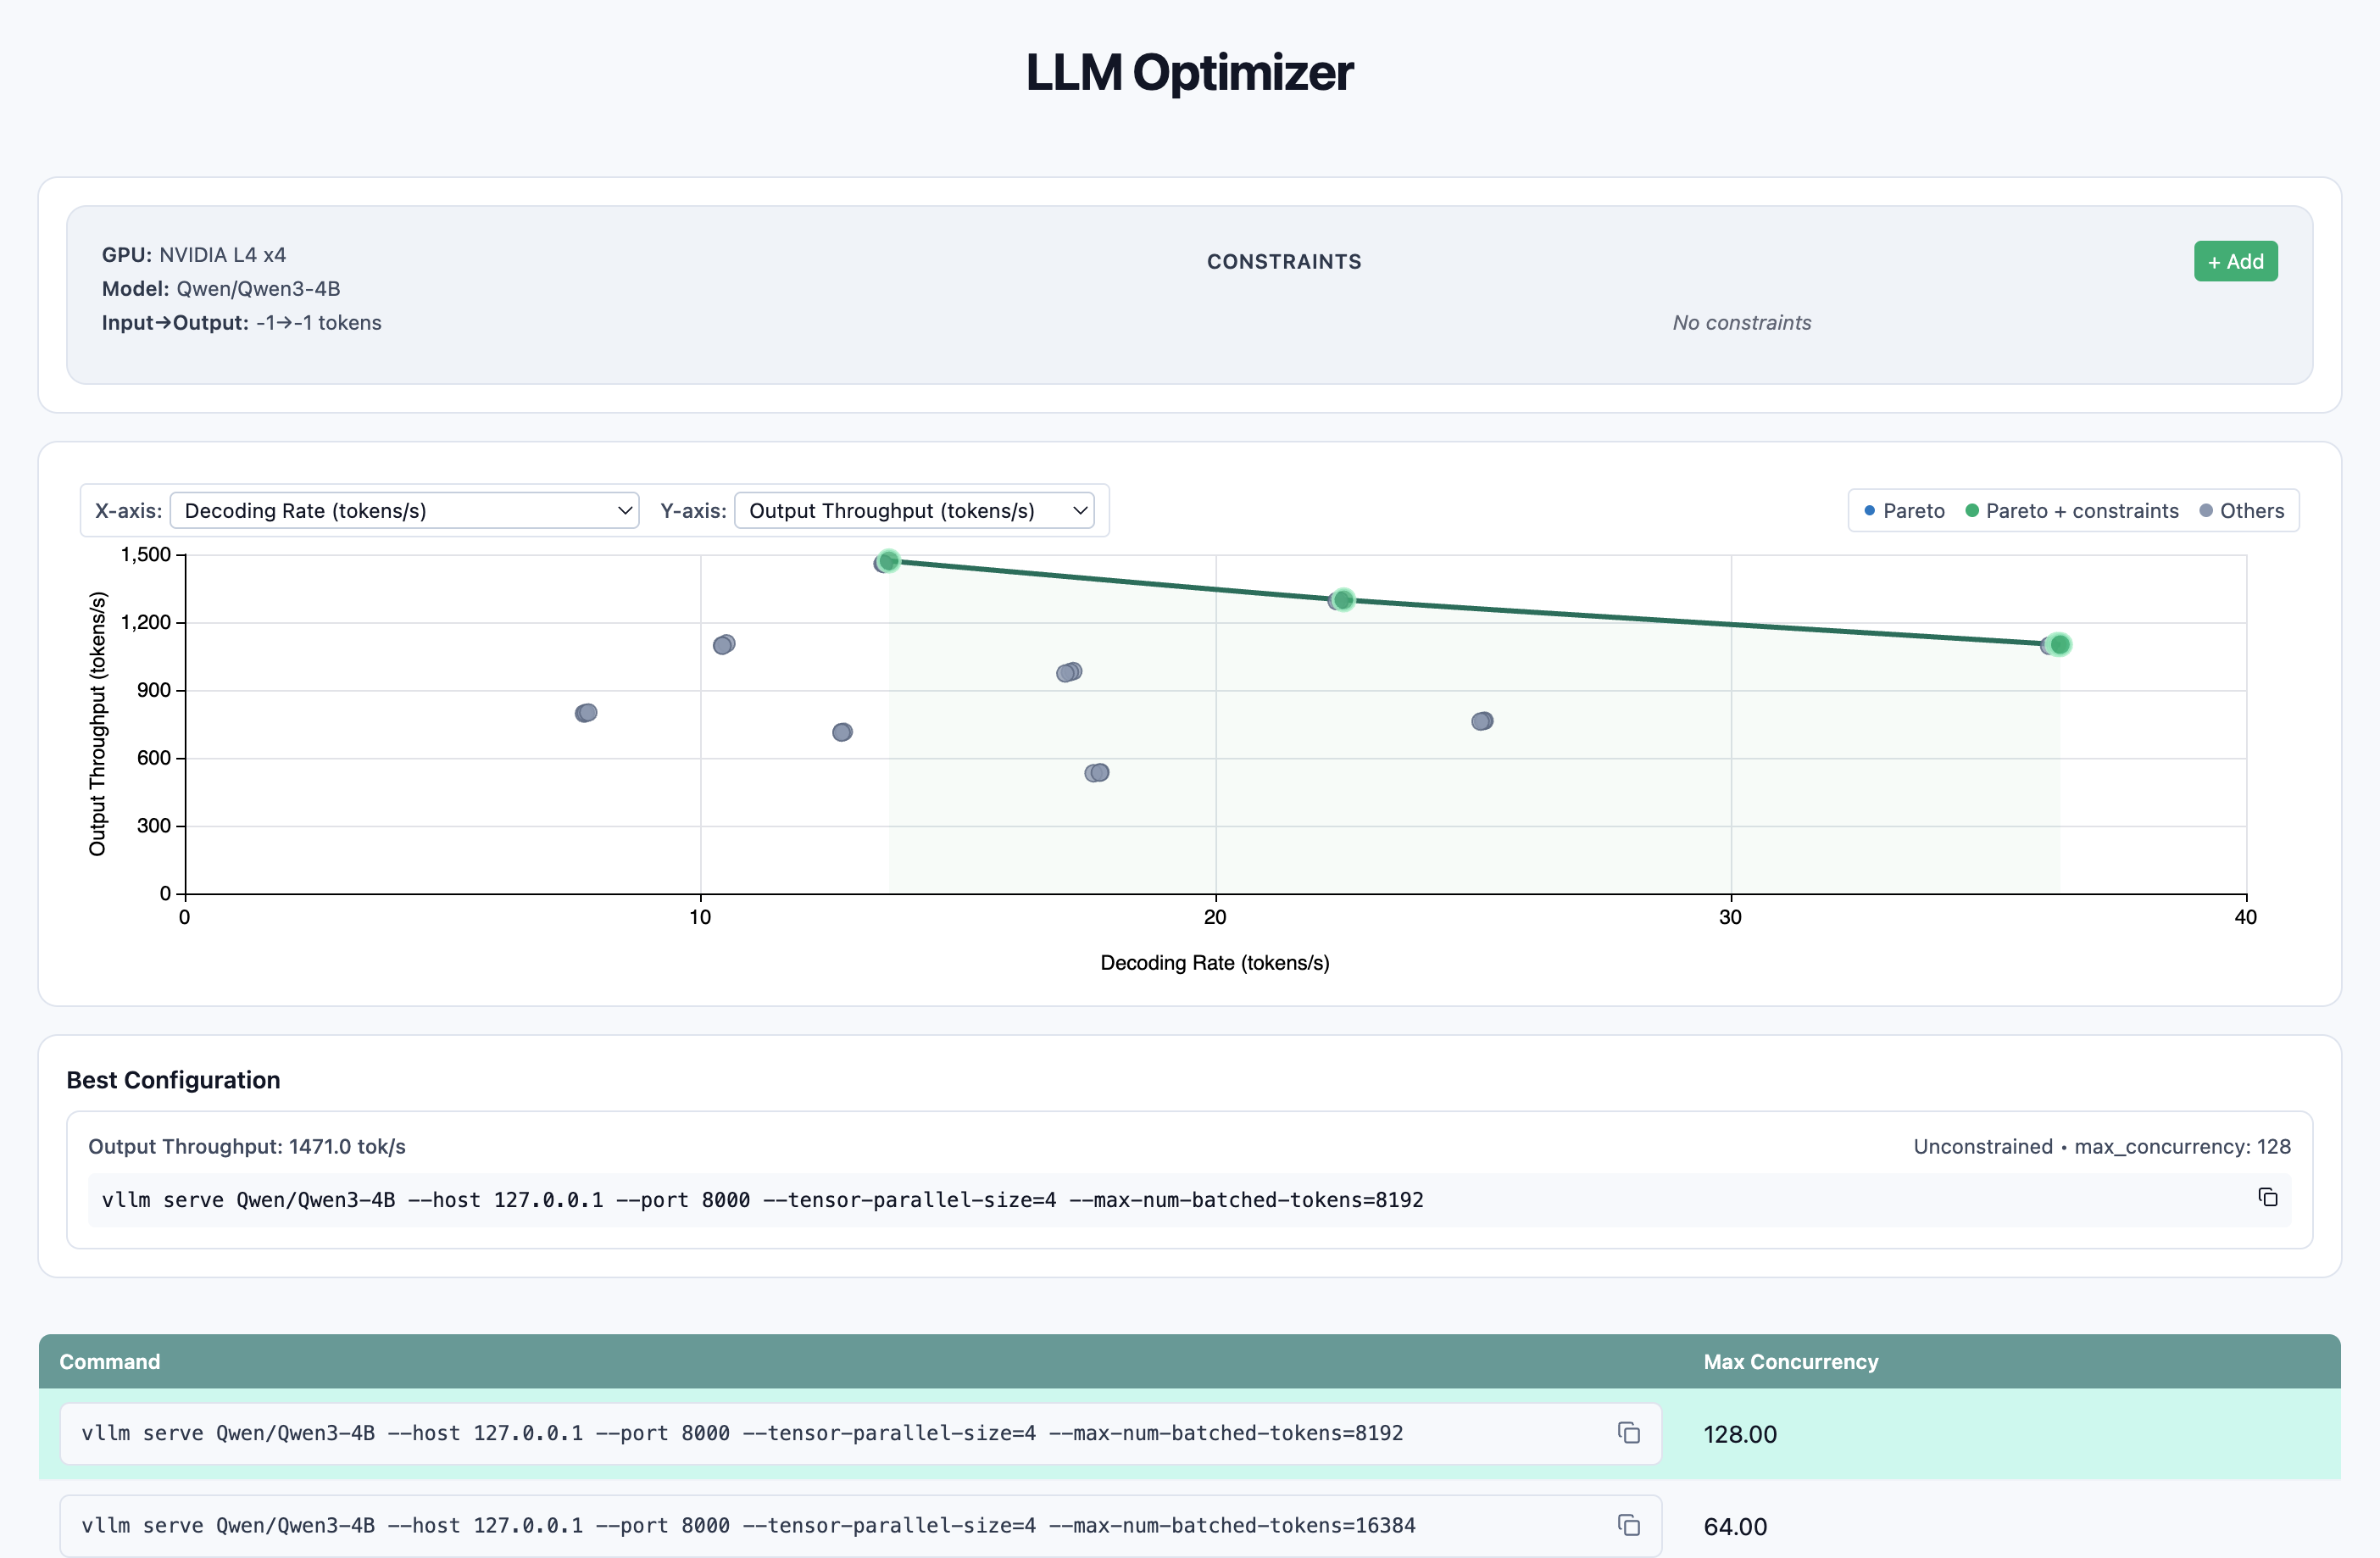

In [3]:
from IPython.display import Image, display
display(Image(filename='vllm_results.png'))

### Deploying to Amazon SageMaker AI

With optimal serving parameters identified, we deploy the tuned model to production using:

**SageMaker AI LMI Containers**:
- High-performance Docker images designed for LLM inference
- Native integration with vLLM and SGLang frameworks
- Built-in support for multi-GPU tensor parallelism, continuous batching, streaming
- LMI v16 container includes vLLM v0.10.2 with V1 engine

**Configuration via Environment Variables**:
The optimal parameters from benchmarking are passed directly to the container as environment variables, ensuring the model runs with the same validated settings.

## Using the results for optimal serving with vLLM

In [ ]:
!pip install sagemaker boto3 huggingface-hub --upgrade --quiet

In [ ]:
import sagemaker
import boto3
import json
from sagemaker.utils import name_from_base

In [2]:
role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts
model_bucket = sess.default_bucket()  # bucket to house artifacts

region = sess._region_name
account_id = sess.account_id()

s3_client = boto3.client("s3")
sm_client = boto3.client("sagemaker")
smr_client = boto3.client("sagemaker-runtime")

The env settings can be derived directly from the jsonl record created for us after benchmarking, which is also the suggested record shown in the screenshot above:
```json
{
    "config": {
        "client_args": {
            "max_concurrency": 128,
            "num_prompts": 1000,
            "dataset_name": "sharegpt"
        },
        "server_args": {
            "tensor_parallel_size": 4,
            "max_num_batched_tokens": 8192
        },
        "server_cmd_args": [
            "--tensor-parallel-size=4",
            "--max-num-batched-tokens=8192"
        ]
    },
    ...
    "cmd": "vllm serve Qwen/Qwen3-4B --host ********* --port 8000 --tensor-parallel-size=4 --max-num-batched-tokens=8192",
    "constraints": [],
    "metadata": {
        "gpu_type": "NVIDIA L4",
        "gpu_count": 4,
        "model_tag": "Qwen/Qwen3-4B",
        "input_tokens": -1,
        "output_tokens": -1
    }
}
```

In [ ]:
env = {
    "HF_MODEL_ID": "Qwen/Qwen3-4B",
    "OPTION_ASYNC_MODE": "true",
    "OPTION_ROLLING_BATCH": "disable",
    "OPTION_MAX_NUM_BATCHED_TOKENS": "8192",
    "OPTION_ENTRYPOINT": "djl_python.lmi_vllm.vllm_async_service",
    "OPTION_TENSOR_PARALLEL_DEGREE": "max",
}

In [4]:
image_uri = f"763104351884.dkr.ecr.{region}.amazonaws.com/djl-inference:0.34.0-lmi16.0.0-cu128"
model_name = name_from_base("qwen3-4b-optimized")

create_model_response = sm_client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = {
        "Image": image_uri,
        "Environment": env,
    },
)
model_arn = create_model_response["ModelArn"]

In [ ]:
endpoint_config_name = f"{model_name}-config"
endpoint_name = f"{model_name}-endpoint"

endpoint_config_response = sm_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_name,
            "InstanceType": "ml.g6.12xlarge",
            "InitialInstanceCount": 1,
            "ModelDataDownloadTimeoutInSeconds": 1800,
            "ContainerStartupHealthCheckTimeoutInSeconds": 1800,
        },
    ],
)
print(f"endpoint_name: {endpoint_name}")

In [6]:
create_endpoint_response = sm_client.create_endpoint(
    EndpointName=endpoint_name, EndpointConfigName=endpoint_config_name
)

In [ ]:
import time

resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
status = resp["EndpointStatus"]
print("Status: " + status)

while status == "Creating":
    time.sleep(60)
    resp = sm_client.describe_endpoint(EndpointName=endpoint_name)
    status = resp["EndpointStatus"]
    print("Status: " + status)

print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

In [8]:
request = {
    "messages": [
            {"role": "user", "content": "What is Amazon SageMaker?"}
            ],
            "max_tokens": 50,
            "temperature": 0.75,
            "stop": None
}

In [9]:
%%time

response_model = smr_client.invoke_endpoint(
    EndpointName=endpoint_name,
    Body=json.dumps(request),
    ContentType="application/json",
)

response = response_model["Body"].read()
response

CPU times: user 4.17 ms, sys: 7.12 ms, total: 11.3 ms
Wall time: 1.27 s


b'{"id":"chatcmpl-0adfc8a5ca0d4091be4ea9d0af117d7d","object":"chat.completion","created":1761847840,"model":"lmi","choices":[{"index":0,"message":{"role":"assistant","content":"<think>\\nOkay, the user is asking about Amazon SageMaker. I need to explain what it is. Let me start by recalling the basics. SageMaker is a service by AWS for machine learning. It\'s designed to help users build, train,","refusal":null,"annotations":null,"audio":null,"function_call":null,"tool_calls":[],"reasoning_content":null},"logprobs":null,"finish_reason":"length","stop_reason":null,"token_ids":null}],"service_tier":null,"system_fingerprint":null,"usage":{"prompt_tokens":14,"total_tokens":64,"completion_tokens":50,"prompt_tokens_details":null},"prompt_logprobs":null,"prompt_token_ids":null,"kv_transfer_params":null}\n'

In [11]:
from pprint import pprint
pprint(json.loads(response))

{'choices': [{'finish_reason': 'length',
              'index': 0,
              'logprobs': None,
              'message': {'annotations': None,
                          'audio': None,
                          'content': '<think>\n'
                                     'Okay, the user is asking about Amazon '
                                     'SageMaker. I need to explain what it is. '
                                     'Let me start by recalling the basics. '
                                     'SageMaker is a service by AWS for '
                                     "machine learning. It's designed to help "
                                     'users build, train,',
                          'function_call': None,
                          'reasoning_content': None,
                          'refusal': None,
                          'role': 'assistant',
                          'tool_calls': []},
              'stop_reason': None,
              'token_ids': None}],
 'crea

## Cleanup 

In [ ]:
sm_client.delete_endpoint(EndpointName=endpoint_name)
sm_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)